# News Mood

## Analysis
 - Tweet sentiment for BBC News and the New York Times is primarily neutral.
 - Tweet sentiment for CNN and Fox News is slightly negative.
 - Tweet sentiment for CBS News is heavily negative compared to the other four media outlets. 

In [1]:
%matplotlib inline

In [2]:
# Dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tweepy
from datetime import datetime
 
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (consumer_key,
                    consumer_secret,
                    access_token,
                    access_token_secret)

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target User Accounts
target_users = ["@BBCNews","@CBSNews","@CNN","@FoxNews","@nytimes"]

# Variables for holding data
tweet_source = []
tweet_dates = []
tweet_texts = []
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for user in target_users:
    
    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(1, 6):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, page=x)

        # Loop through all tweets
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            
            #Convert tweet creation dates to datetime objects
            tweet_datetime = datetime.strptime(tweet["created_at"], "%a %b %d %H:%M:%S %z %Y")
            
            # Add each value to the appropriate list
            tweet_source.append(user)
            tweet_dates.append(tweet_datetime)
            tweet_texts.append(tweet['text'])
            compound_list.append(compound)
            positive_list.append(pos)
            negative_list.append(neg)
            neutral_list.append(neu)

In [7]:
#Create dataframe to store list data
df_sentiments = pd.DataFrame()
df_sentiments['source'] = tweet_source
df_sentiments['date'] = tweet_dates
df_sentiments['tweet'] = tweet_texts
df_sentiments['compound_score'] = compound_list
df_sentiments['positive_score'] = positive_list
df_sentiments['neutral_score'] = neutral_list
df_sentiments['negative_score'] = negative_list

#Reorder columns
df_sentiments = df_sentiments[['source','date','compound_score','positive_score','neutral_score','negative_score','tweet']]

#Export dataframe to CSV
df_sentiments.to_csv('twitter_news_sentiments.csv',index=False)


In [24]:
#Create dataframes for charts
df_compound_scores = df_sentiments[['source','date','compound_score']]
df_BBCNews = df_compound_scores[df_compound_scores.source=='@BBCNews'].sort_values('date',ascending=False)
df_CBSNews = df_compound_scores[df_compound_scores.source=='@CBSNews'].sort_values('date',ascending=False)
df_CNN = df_compound_scores[df_compound_scores.source=='@CNN'].sort_values('date',ascending=False)
df_FoxNews = df_compound_scores[df_compound_scores.source=='@FoxNews'].sort_values('date',ascending=False)
df_NYT = df_compound_scores[df_compound_scores.source=='@nytimes'].sort_values('date',ascending=False)



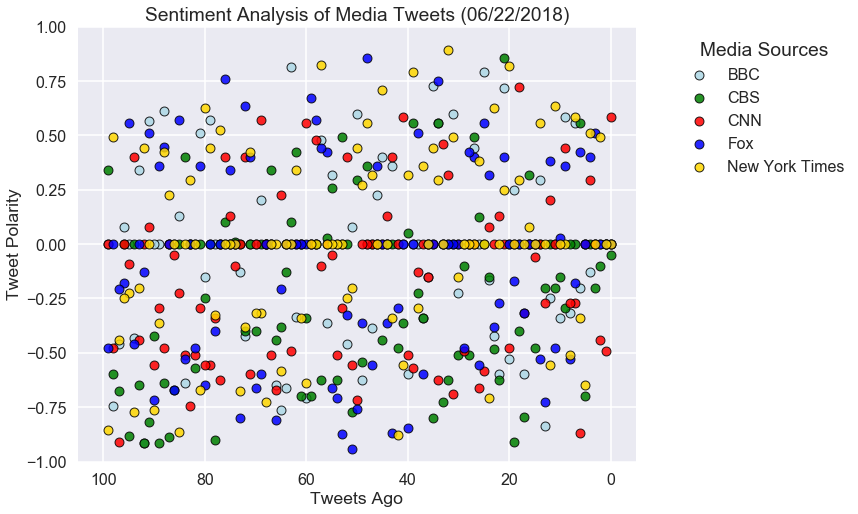

In [45]:
#Plot scatterplot
current_date = datetime.today().strftime('%m/%d/%Y')

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(range(len(df_BBCNews)),
           df_BBCNews['compound_score'],
           s=80,
           label='BBC',
           marker='o',
           facecolors='lightblue',
           edgecolor='black',
           linewidths=1,
           alpha=0.85
          )

ax.scatter(range(len(df_CBSNews)),
           df_CBSNews['compound_score'],
           s=80,
           label='CBS',
           marker='o',
           facecolors='green',
           edgecolor='black',
           linewidths=1,
           alpha=0.85
          )

ax.scatter(range(len(df_CNN)),
           df_CNN['compound_score'],
           s=80,
           label='CNN',
           marker='o',
           facecolors='red',
           edgecolor='black',
           linewidths=1,
           alpha=0.85
          )

ax.scatter(range(len(df_FoxNews)),
           df_FoxNews['compound_score'],
           s=80,
           label='Fox',
           marker='o',
           facecolors='blue',
           edgecolor='black',
           linewidths=1,
           alpha=0.85
          )

ax.scatter(range(len(df_NYT)),
           df_NYT['compound_score'],
           s=80,
           label='New York Times',
           marker='o',
           facecolors='gold',
           edgecolor='black',
           linewidths=1,
           alpha=0.85
          )

#Format legend
plt.legend(title='Media Sources',loc='upper right', bbox_to_anchor=(1.4,1))

plt.title(f'Sentiment Analysis of Media Tweets ({current_date})')
plt.xlabel('Tweets Ago')
plt.ylabel('Tweet Polarity')
plt.xlim(105,-5)
plt.ylim(-1,1)

sns.set_style('darkgrid')
sns.set_context('poster')

plt.show()
plt.savefig('sentiment_analysis.png')



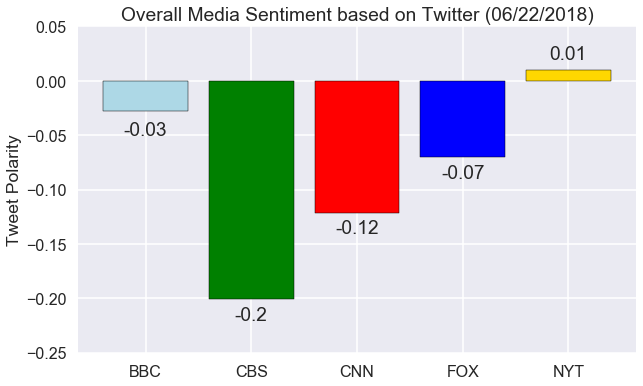

In [70]:
#Plot bar chart

#Group compound sentiment scores by source
df_overall_score = df_compound_scores.groupby(df_compound_scores.source)

#Create dataframe to store aggregate compound score
df_score_summary = pd.DataFrame()
df_score_summary['overall_score'] = df_overall_score.compound_score.mean()

plt.figure(figsize=(10,6))
plt.bar(df_score_summary.index,
        df_score_summary.overall_score,
        tick_label=['BBC','CBS','CNN','FOX','NYT'],
        color=['lightblue','green','red','blue','gold'],
        edgecolor='black'
       )

#Create data labels for each bar
for a,b in zip(df_score_summary.index, np.around(df_score_summary.overall_score,2)):
    if b < 0:
        plt.text(a, b-0.02, str(b), horizontalalignment='center')
    else:
        plt.text(a, b+0.01, str(b), horizontalalignment='center')

plt.title(f'Overall Media Sentiment based on Twitter ({current_date})')
plt.ylabel('Tweet Polarity')
plt.ylim(-0.25,0.05)

sns.set_style('darkgrid')
sns.set_context('poster')

plt.show()
plt.savefig('overall_sentiment.png')